In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from pprint import pprint
import seaborn as sns
import pdb
sns.set_style(style="whitegrid")
from matplotlib import rcParams

%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['figure.figsize'] = 16,8

## Sample Data

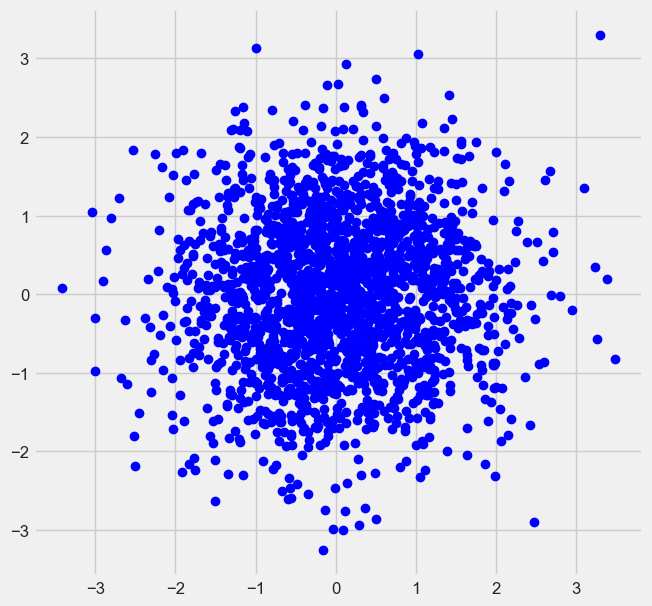

In [2]:
mean = [0, 0]
cov = [[1, 0], [0, 1]]  # diagonal covariance
Nobjs = 2000
x, y = np.random.multivariate_normal(mean, cov, Nobjs).T
#Add manual outlier
x[0]=3.3
y[0]=3.3
X=np.array([x,y]).T
X = pd.DataFrame(X,columns=['feat1','feat2'])
plt.figure(figsize=(7,7))
plt.plot(x,y,'bo');
plt.show()

## Isolation tree
    - Randomly select dimension
    - Randomly pick a value in the dimension
    - Split the data

In [3]:
def select_feature(data): 
    '''
    Randomly select a feature of a dataframe
    '''
    return random.choice(data.columns)

def select_value(data,feat):
    '''
    Select values of 
    '''
    mini = data[feat].min()
    maxi = data[feat].max()
    return (maxi-mini)*np.random.random()+mini

def split_data(data, split_column, split_value):
    '''
    Split data based on the value of a column
    '''
    data_below = data[data[split_column] <= split_value]
    data_above = data[data[split_column] >  split_value]
    
    return data_below, data_above

def classify_data(data):
    
    label_column = data.values[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

def isolation_tree(data,counter=0, max_depth=50):
    if max_depth is None: 
        max_depth=float("inf")
    # End Loop
    if (counter == max_depth) or data.shape[0]<=1:
        classification = classify_data(data)
        return classification,counter
    
    else:
        # Counter
        counter +=1
        
        # Select feature
        split_column = select_feature(data)
        
        # Select value
        split_value = select_value(data,split_column)

        # Split data
        data_below, data_above = split_data(data,split_column,split_value)
        
        # instantiate sub-tree      
        question = "{} <= {}".format(split_column, split_value)
        sub_tree = {question: []}
        
        # Recursive part
        below_answer,counter = isolation_tree(data_below, counter,max_depth=max_depth)
        above_answer,counter = isolation_tree(data_above, counter,max_depth=max_depth)
        
        if below_answer == above_answer:
            sub_tree = below_answer
        else:
            sub_tree[question].append(below_answer)
            sub_tree[question].append(above_answer)
        
        return sub_tree,counter
    

 ## Isolation Forest
    - For each tree
    - Sample Data
    - Fit tree

In [4]:
def isolation_forest(df,n_trees=5, max_depth=5, subspace=256):
    if max_depth is None: 
        max_depth=float("inf")
    if subspace<=1:
        subspace=subspace*df.shape[0]
    forest = []
    depth=[]

    for i in range(n_trees):
        # Sample the subspace
        if subspace<=1:
            df = df.sample(frac=subspace)
        else:
            df = df.sample(subspace)
        

        # Fit tree
        tree,dt = isolation_tree(df,max_depth=max_depth)
        
        # Save tree to forest
        forest.append(tree)
        depth.append(dt)
    
    return forest,depth

## Path Length

In [5]:
def pathLength(example,iTree,path=0,trace=False):
    
    path=path+1
    question = list(iTree.keys())[0]
    
    feature_name, comparison_operator, value = question.split()
    
    if example[feature_name].values <= float(value):
        answer = iTree[question][0]
    else:
        answer = iTree[question][1]
        
        
    # base case
    if not isinstance(answer, dict):
        return path
    
    # recursive part
    else:
        residual_tree = answer
        return pathLength(example, residual_tree,path=path)

    return path

## Evaluate

In [6]:
def evaluate_instance(instance,forest):
    paths = []
    for tree in forest:
        paths.append(pathLength(instance,tree))
    return paths 

In [7]:
def c_factor(n) :
    return 2.0*(np.log(n-1)+0.5772156649) - (2.0*(n-1.)/(n*1.0))

In [8]:
def anomaly_score(data_point,forest,n):
    
    # Mean depth for an instance
    E = np.mean(evaluate_instance(data_point,forest))
    
    c = c_factor(n)
    
    return 2**-(E/c)

## Model Training

In [9]:
iForest,depth = isolation_forest(X,n_trees=20, max_depth=None, subspace=256)

In [10]:
decision_score= []
for i in range(X.shape[0]):
    decision_score.append(anomaly_score(X.iloc[[i]],iForest,256))

In [11]:
def predict(contamination, decision_score):
    prediction = []
    total_contamination = int(contamination * len(decision_score))
    anomaly_score = np.sort(np.array(decision_score))[::-1]
    anomaly_score = anomaly_score[:total_contamination]
    for score in decision_score:
        if score in anomaly_score:
            prediction.append(-1)
        else:
            prediction.append(1)
    return prediction
    

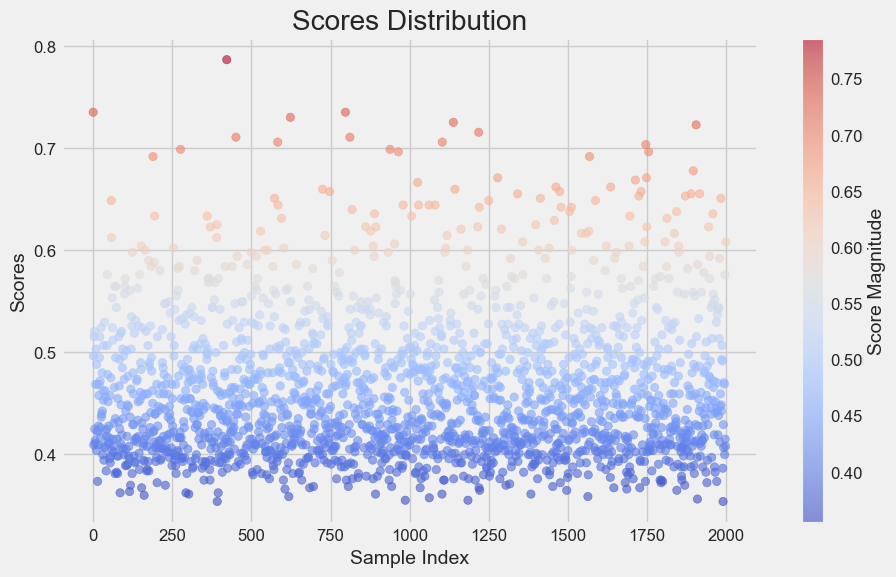

In [12]:
# Plot the scores with a gradient colormap
plt.figure(figsize=(10, 6))
plt.scatter(range(len(decision_score)), decision_score, c=decision_score, cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Score Magnitude')
plt.xlabel('Sample Index')
plt.ylabel('Scores')
plt.title('Scores Distribution')
plt.grid(True)
plt.show()

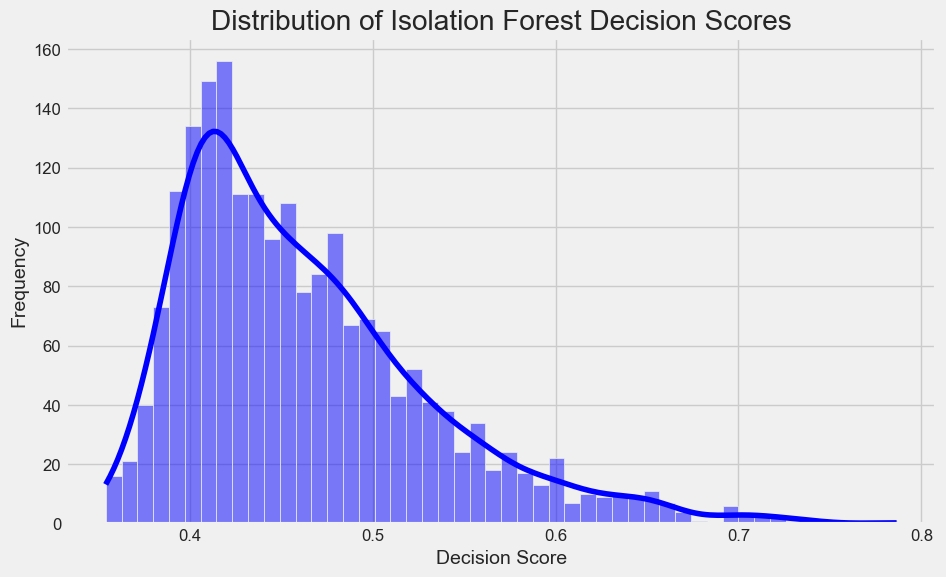

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(decision_score, bins=50, kde=True, color='blue')
plt.title('Distribution of Isolation Forest Decision Scores')
plt.xlabel('Decision Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

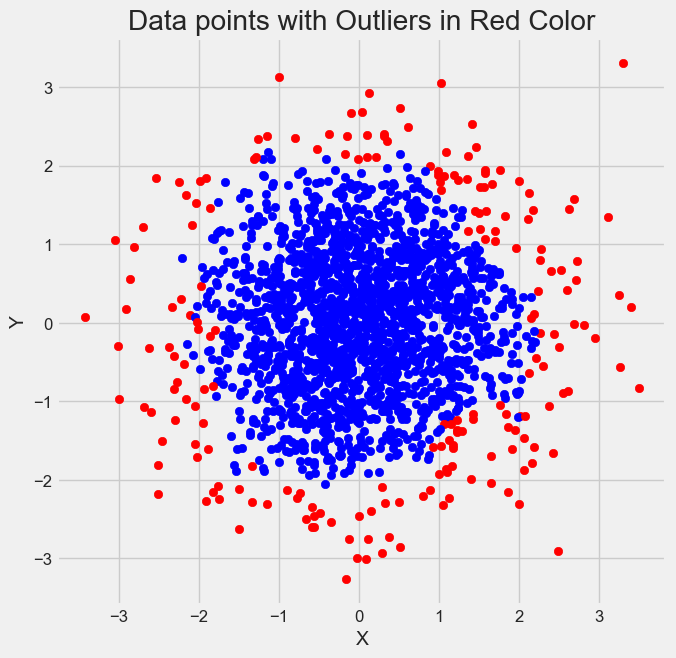

In [14]:
prediction=predict(0.1,decision_score)

plt.figure(figsize=(7, 7))

# Plotting data points with specific colors based on prediction
for i in range(len(x)):
    color = 'r' if prediction[i] == -1 else 'b'
    plt.scatter(x[i], y[i], color=color)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data points with Outliers in Red Color')
plt.grid(True)
plt.show()

In [15]:
### Depth of each tree
print(depth)

[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]
